# CME 241 Assignment 2
## Shaan Patel


### Question 1

The state space for the Snakes and Ladders game is all numbers from
0 to 100. However, with the addition of the snakes and ladders, we remove
certain numbers and replace them with their destination tile (i.e. the 1
tile has a ladder to 38, so 1 is removed).

In terms of transition probabilities, the distributions all follow the 
distribution of a 6 sided dice roll. However, the snakes and ladders lead to
different results for each space. For example, the distribution at state 0 is:

```math
38, 1/6
2, 1/6
3, 1/6
14, 1/6
5, 1/6
6, 1/6
```

More generally, let us assume a ladder going to $s'$ is denoted as $l$ and a snake going to $s'$ is $n$. Then, given we are on space $s$, the probability of landing on $s'$ is:


$$1/6,  l||n||s' - s \le 6, s < l||n||s'$$
$$1/3,  (l,s') || (n,s) - s \le 6, s < (l,s') || (n,s') $$
$$1/2, (l,n,s') - s \le 6, s < l,n,s' $$

These distributions show that if $s$ and $s'$ are within six spaces of each other, then the probability of achieving $s'$ is 1/6. This probability doubles if a ladder or snake are also within six spaces of $s$, and triples if all three are within one dice roll of $s$. If all three spaces are below $s$ or greater than 6 away from $s$, the probability is 0.

In the current implementation of the game, however, there is no space that has both a ladder and snake pointing to it, so the third line is irrelevant. In addition, there are only two occasions in which the probablility is 1/3; going to space 53 (snake at space 56) and going to space 60 (snake at space 64). Aside from these edge cases, the probability of landing on $s'$ given that we are on $s$ is 1/6 if $s$ is within 6 spaces of $s'$, its corresponding ladder, or its corresponding snake.


### Question 2

In [12]:
import itertools
import math
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Mapping
from rl.distribution import Categorical, FiniteDistribution
from rl.markov_process import (FiniteMarkovProcess, MarkovProcess,
                                MarkovRewardProcess, FiniteMarkovRewardProcess,
                                NonTerminal, State)


In [2]:
class SnakesAndLadders(FiniteMarkovProcess[int]):
    def __init__(self, p):
        irregulars = {1,4,9,16,21,28,36,47,49,51,56,62,64,71,80,87,93,95,98}
        change = {1:38, 4:14, 9:31, 16:6,
                21:42, 28:84, 36:44, 47:26, 
                49:11, 51:67, 56:53, 62:19,
                64:60, 71:91, 80:100, 87:24,
                93:73, 95:75, 98:78}
        regulars = set(range(0,106))
        regulars = regulars.difference(irregulars)
        transition_map = {
            b : Categorical({(b+x if b+x in regulars else change[b+x]): (1/p)
                for x in range(1,p)}
            ) for b in range(0,99)
        }
        super().__init__(transition_map)

In [3]:
simulation = SnakesAndLadders(6)
startstate = simulation.transition(NonTerminal(0))
tracer = simulation.traces(startstate)
runcounter = itertools.islice(tracer, 10000)
rundata = []
for run in runcounter:
    count = sum(1 for i in run)
    rundata.append(count)



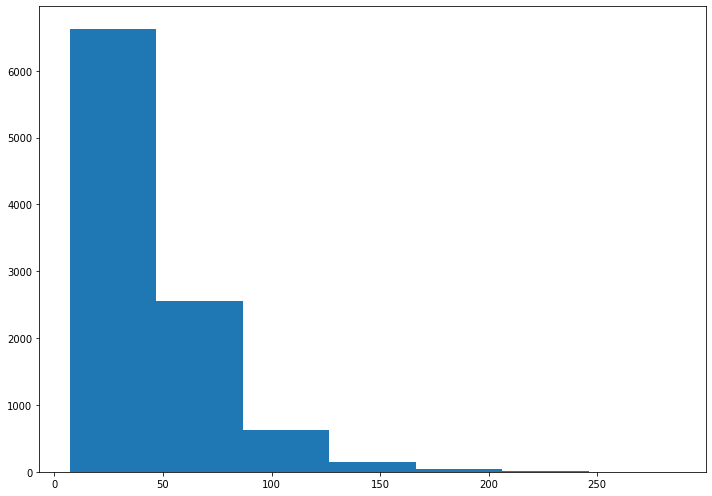

In [4]:
fig, ax = plt.subplots(1,1, figsize = (10,7), tight_layout = True)
ax.hist(rundata, bins = 7)
plt.show()

### Question 3

In the frog puzzle, we need to figure out the expected number of jumps it will take the frog to cross a river with $n - 1$ lilypads between itself and the other bank.

If the frog is $n$ spaces away, we can see that there is a recurrence relation between $E[n]$ and the expected value of the space it lands on.

$$ E[n] = 1 + \frac{1}{n} \sum_{i=1}^{n-1} E[i]$$

This is the sum of expected jumps from each space it lands on plus the one jump to get there.
In the case of $n - 1$ spaces, there is a similar relation:

$$ E[n - 1] = 1 + \frac{1}{n-1}\sum_{i=1}^{n-2} E[i] $$

As a result, we can see that each space is a Markov process with transition probability of $1/n$. If we scale and subtract these two equations, we get the following:

$$ nE[n] - (n-1)E[n-1] = n - (n-1) + E[n-1] $$

$$ = 1 + E[n - 1] $$

When solving for $E[n]$, we get:

$$ E[n] = \frac{1}{n} + E[n-1] $$

This is the expected value form of the harmonic series $\sum_{i=1}^n \frac{1}{i} $. While this series does not converge and has no closed form solution, it does diverge very slowly, and its partial sums can be found through summation. For the $n = 10$ case, the expected number of jumps is equal to the 10th harmonic number (i.e. $\sum_{i=1}^{10} \frac{1}{i} $, or approximately 2.928968. In the general case, the expected number of jumps for the frog is the n'th harmonic number.







### Question 4

In [16]:
class SnakeLadderReward(FiniteMarkovRewardProcess[int]):
    def __init__(self, p: int, startreward: int):
        self.p: int = p
        self.startreward: int = startreward
        super().__init__(self.get_transition_reward_map())
    
    
    def get_transition_reward_map(self) -> \
            Mapping[
                int,
                FiniteDistribution[Tuple[int, int]]
            ]:
        irregulars = {1,4,9,16,21,28,36,47,49,51,56,62,64,71,80,87,93,95,98}
        change = {1:38, 4:14, 9:31, 16:6,
                21:42, 28:84, 36:44, 47:26, 
                49:11, 51:67, 56:53, 62:19,
                64:60, 71:91, 80:100, 87:24,
                93:73, 95:75, 98:78}
        regulars = set(range(0,106))
        regulars = regulars.difference(irregulars)
        d = {
            b: Categorical({(b+x if b+x in regulars else change[b+x], 1): (1/self.p)
                for x in range(1, self.p)}
            ) for b in range(0,100) 
        }
            

        self.transition_map = {
            b : Categorical({(b+x if b+x in regulars else change[b+x]): (1/self.p)
                for x in range(1,self.p)}
            ) for b in range(0,100)
        }

        return d
        
                    

In [17]:
reward = SnakeLadderReward(6, 0)
reward.display_value_function(1)


{NonTerminal(state=2): 43.886,
 NonTerminal(state=1): 44.047,
 NonTerminal(state=0): 43.128,
 NonTerminal(state=21): 38.159,
 NonTerminal(state=22): 38.175,
 NonTerminal(state=23): 35.736,
 NonTerminal(state=24): 36.651,
 NonTerminal(state=25): 37.364,
 NonTerminal(state=26): 37.87,
 NonTerminal(state=15): 40.458,
 NonTerminal(state=16): 39.307,
 NonTerminal(state=17): 39.119,
 NonTerminal(state=18): 38.555,
 NonTerminal(state=19): 38.237,
 NonTerminal(state=20): 38.092,
 NonTerminal(state=8): 42.815,
 NonTerminal(state=7): 43.083,
 NonTerminal(state=6): 43.289,
 NonTerminal(state=5): 43.419,
 NonTerminal(state=4): 43.601,
 NonTerminal(state=3): 43.708,
 NonTerminal(state=9): 42.922,
 NonTerminal(state=10): 42.511,
 NonTerminal(state=11): 42.641,
 NonTerminal(state=12): 42.054,
 NonTerminal(state=13): 41.471,
 NonTerminal(state=14): 40.932,
 NonTerminal(state=87): 16.235,
 NonTerminal(state=88): 16.873,
 NonTerminal(state=89): 15.894,
 NonTerminal(state=90): 16.054,
 NonTerminal(state=

We made the rewards in the Markov Reward Process 1 such that each time a state was entered, the total rewards would increment. This would cause the calculation of the value function (expected reward given state $s$) to calculate the expected number of dice rolls from that state to the terminal state (100).